In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py', 'lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBSSBSS'
m = 'TOBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [2]:
# register table
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT latitude, longitude FROM weather"
df1 = sqlContext.sql(Query)

In [3]:
df1.describe().show()

+-------+-------------------+-------------------+
|summary|           latitude|          longitude|
+-------+-------------------+-------------------+
|  count|              12473|              12473|
|   mean|  42.21749882947232|-107.74631615489349|
| stddev|0.45836447476053366| 1.9239042879330641|
|    min|               41.4|             -111.0|
|    max|              42.85|          -104.9128|
+-------+-------------------+-------------------+



In [11]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)

def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='[coeffient for eig3]    %s / %d \ncoeffient=%f    risidual=%f'%(row['station'],row['year'],row['coeff_3'],row['res_3'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=2, row_n=2, figsize=(15,6)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n, column_n, sharex='col', sharey='row',figsize=figsize);
    plt.subplots_adjust(hspace = .5)
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[i*2+j]
            k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],interactive=False)
    return None

# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df2.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    plot([vals[0]] + vals,P)
    #plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

In [5]:
df=df.filter(df.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1925.1|   41.45|-105.2333|       TOBS|USC00484700|     2|[00 46 80 C9 80 5...|1956.0|SBBSSBSS|
|   1925.1|   41.45|-105.2333|       TOBS|USC00484700|     3|[00 00 40 4C 00 C...|1957.0|SBBSSBSS|
|   1925.1|   41.45|-105.2333|       TOBS|USC00484700|     1|[00 00 00 C6 00 0...|1958.0|SBBSSBSS|
|   1925.1|   41.45|-105.2333|       TOBS|USC00484700|     7|[00 7E 00 7E 00 7...|1959.0|SBBSSBSS|
|   1925.1|   41.45|-105.2333|       TOBS|USC00484700|    11|[28 D8 F0 D6 A0 D...|1960.0|SBBSSBSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']

v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [7]:
df

DataFrame[elevation: double, latitude: double, longitude: double, measurement: string, station: string, undefs: bigint, vector: binary, year: double, label: string]

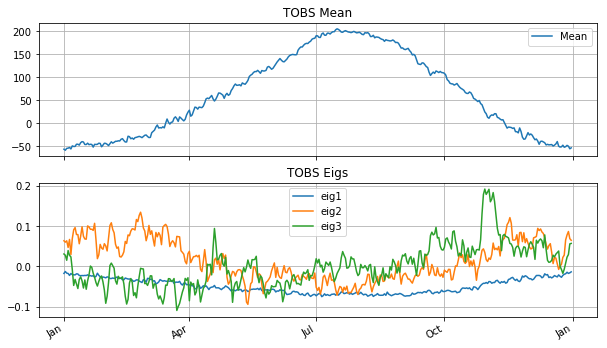

In [8]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

DataFrame[coeff_1: double, coeff_2: double, coeff_3: double, elevation: double, label: string, latitude: double, longitude: double, measurement: string, res_1: double, res_2: double, res_3: double, res_mean: double, station: string, total_var: double, undefs: bigint, vector: binary, year: double]
before filter 1714
after filter 1493


/Users/hogan/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


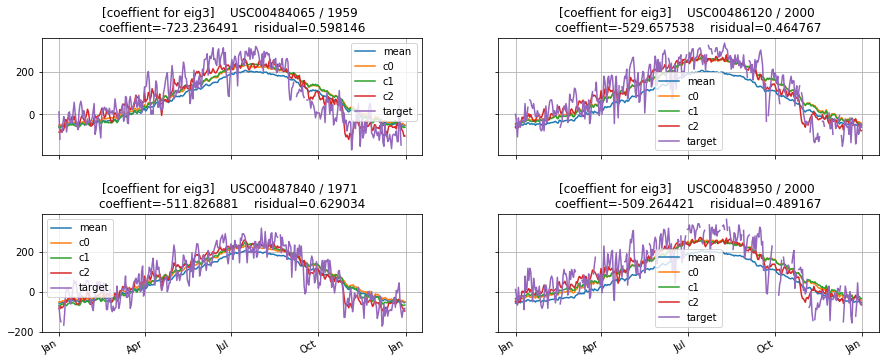

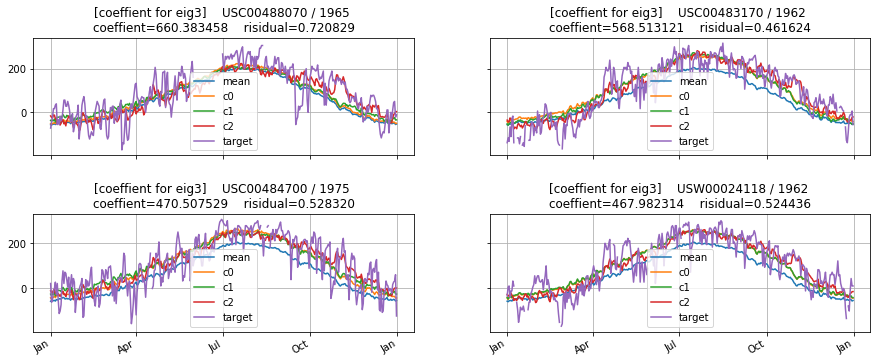

In [9]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print df2
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

#df3=df3.sort(df3.res_2,ascending=True)

# coeff_1
df4=df3.sort(df3.coeff_3)
rows=df4.take(4)
plot_recon_grid(rows)

df4=df3.sort(df3.coeff_3,ascending=False)
rows=df4.take(4)
plot_recon_grid(rows)

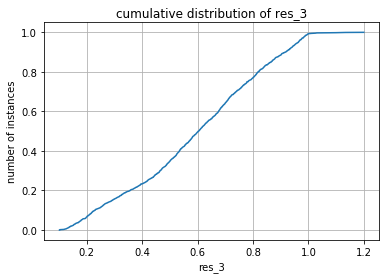

In [12]:
plot_CDF('res_3')

In [13]:
sqlContext.registerDataFrameAsTable(df4,'d_weather')

Query="SELECT station, latitude, longitude, elevation, coeff_1, coeff_2, coeff_3 FROM d_weather"
df5 = sqlContext.sql(Query)

In [14]:
df6=df5.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", "coeff_1": "mean", "coeff_2": "mean", "coeff_3": "mean"})
pdf=df6.toPandas()
pdf.sort_values(by=['station'],inplace=True)

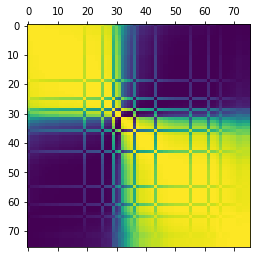

In [15]:
npdf = pdf.set_index('station').loc[:, ['avg(coeff_1)', 'avg(coeff_2)', 'avg(coeff_3)']]
corr = npdf.transpose().corr()
order = np.argsort(corr.iloc[0])
corr_ord = corr.iloc[order,order]
plt.matshow(corr_ord)

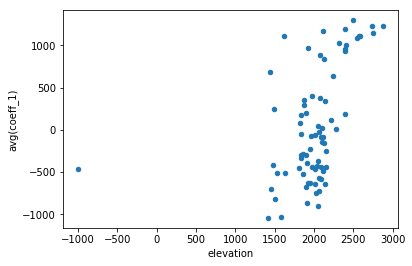

In [18]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');